In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyod.models.hbos import HBOS
from pyod.models.knn import KNN
from pyod.models.cblof import CBLOF
from pyod.models.loda import LODA
from pyod.models.copod import COPOD

In [2]:
plt.style.use('seaborn-dark')

In [3]:
#Set column names and datatypes

column_names = [
    'timestamp', 'duration', 'source_ip', 'dst_ip', 'source_port', 'dst_port',
    'protocol', 'flags', 'forward_status', 'type_of_service', 'packets', 'bytes', 'type'
]

dtypes = {
    #'timestamp': datetime,
    'duration': float,
    'source_ip': str,
    'dst_ip': str,
    'source_port': int,
    'dst_port': int,
    'protocol': str,
    'flags': str,
    'forward_status': int,
    'type_of_service': int,
    'packets': int,
    'bytes': int,
    'type': str
}

In [4]:
#Load data from CSV

df = pd.read_csv('./data/training/uniq/20160318.csv', header=None, names=column_names, dtype=dtypes, parse_dates=[0])
#df2 = pd.read_csv('./data/training/uniq/20160319.csv', header=None, names=column_names, dtype=dtypes, parse_dates=[0])

In [5]:
#Create a copy of loaded dataframe for safe modifications

df_copy = df.copy()

In [104]:
#Count # of connections by hours and minutes

df_group = df_copy.groupby([df['timestamp'].dt.hour, df['timestamp'].dt.minute]).agg(['count'])

In [7]:
#Set basic chart axes

xaxis = np.arange(df_group.shape[0])
yaxis = df_group['timestamp'].values[:,0]

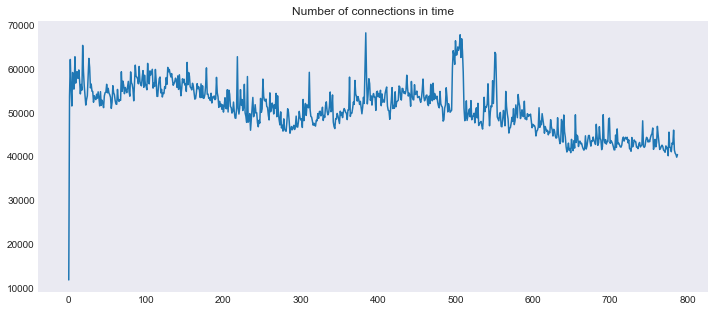

In [87]:
#Plot # of flows

fig = plt.figure(figsize=(12, 5))
plt.plot(xaxis, yaxis)
plt.title('Number of connections in time')
plt.show()

In [ ]:
print(xaxis.shape)
print(yaxis.shape)

In [52]:
#Set model parameters

outlier_fraction = 0.1
X1 = xaxis.reshape(-1, 1)
X2 = yaxis.reshape(-1, 1)
X_train = np.concatenate((X1, X2), axis=1)
X_train.shape

(788, 2)

In [84]:
#Define models and their params for outlier detection

classifiers = {
    'Histogram-Based Outlier Score': HBOS(contamination=outlier_fraction),
    'k Nearest Neighbors': KNN(contamination=outlier_fraction),
    #'Average kNN': KNN(method='mean', contamination=outlier_fraction),
    'Clustering Based Local Outlier Factor': CBLOF(contamination=outlier_fraction),
    #'Lightweight On-line Detection of Anomalies': LODA(contamination=outlier_fraction),
    'Copula Based Outlier Detector': COPOD(contamination=outlier_fraction)
}

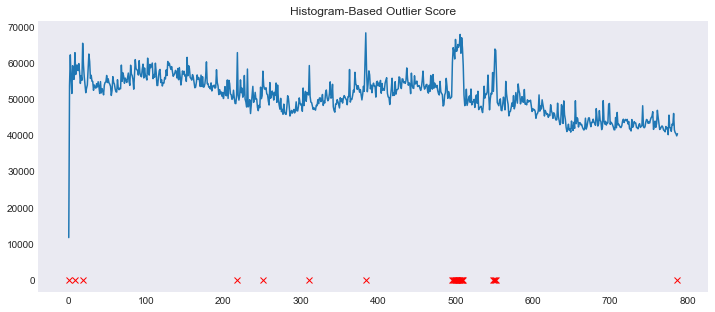

Detection type: Histogram-Based Outlier Score
# of steps: 788
# of detected anomalies: 27
% of detected anomalies: 3.43%


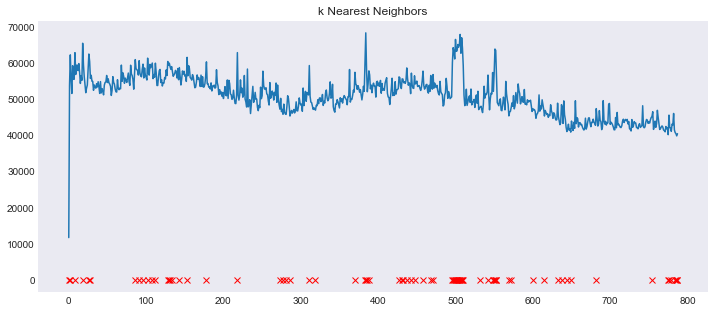

Detection type: k Nearest Neighbors
# of steps: 788
# of detected anomalies: 79
% of detected anomalies: 10.03%


c:\users\kuba\python\network-anomaly-detection\venv\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


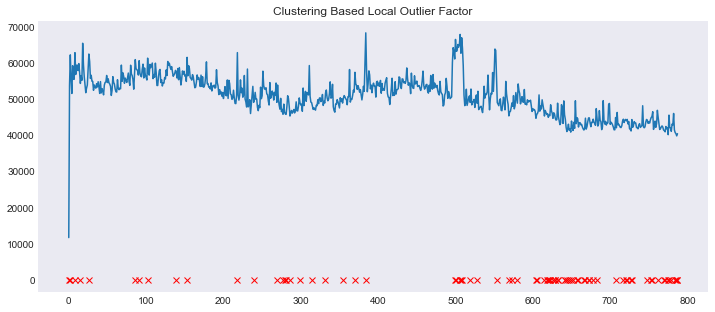

Detection type: Clustering Based Local Outlier Factor
# of steps: 788
# of detected anomalies: 79
% of detected anomalies: 10.03%


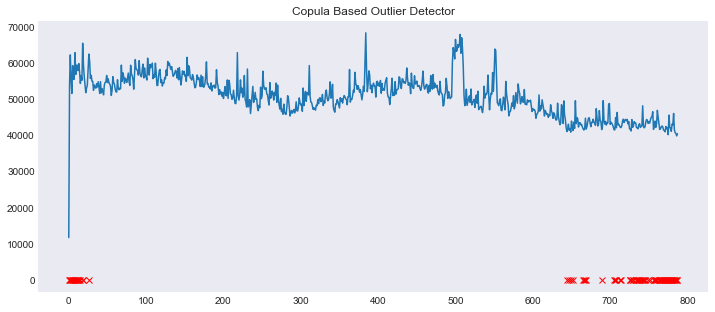

Detection type: Copula Based Outlier Detector
# of steps: 788
# of detected anomalies: 79
% of detected anomalies: 10.03%


In [108]:
for clf_name, clf in classifiers.items():
    clf.fit(X_train)
    y_train_pred = clf.labels_
    y_train_scores = clf.decision_scores_
    scatter = pd.DataFrame([xaxis, y_train_pred]).T
    logicalscatter = scatter[scatter[1] > 0]
    fig = plt.figure(figsize=(12, 5))
    plt.title(clf_name)
    plt.plot(xaxis, yaxis)
    plt.scatter(logicalscatter[0], logicalscatter[1], c='red', marker='x', linewidths=1)
    plt.show()
    outlier_percent = (logicalscatter.shape[0] / X_train.shape[0]) * 100
    print(f'Detection type: {clf_name}')
    print(f'# of steps: {X_train.shape[0]}')
    print(f'# of detected anomalies: {logicalscatter.shape[0]}')
    print(f'% of detected anomalies: {outlier_percent:.2f}%')